In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [27]:
import gdal
import ogr
import osr
import os
import sys

In [28]:
def myGetDataset(filename):
    ds=gdal.Open(filename)
    return ds

In [29]:
def myGetAllArray(dataset):
    all_array=dataset.ReadAsArray()
    return all_array

In [30]:
def myGetBand(dataset,bandNum):
    band=dataset.GetRasterBand(bandNum)
    return band

In [31]:
def myGetArray(band):
    img_array=band.ReadAsArray()
    return img_array

In [32]:
def myGetSpatialRef(dataset):
    img_spaRef=dataset.GetSpatialRef()
    return img_spaRef

In [33]:
def myGetGeoTransform(dataset):
    geoTrans=dataset.GetGeoTransform()
    return geoTrans

In [34]:
def myGetProjection(dataset):  
    img_proj = dataset.GetProjection() #地图投影信息
    return img_proj

In [35]:
def myGetRasterSize(dataset):
    bands=dataset.RasterCount
    width=dataset.RasterXSize
    height=dataset.RasterYSize
    return height,width,bands

In [36]:
def myGetTopLeftCoordinates(dataset):
    geoTrans=myGetGeoTransform(dataset)
    TLx,TLy=(geoTrans[0],geoTrans[3])
    return TLx,TLy

In [37]:
def myGetPixelSize(dataset):
    geoTrans=myGetGeoTransform(dataset)
    px,py=(geoTrans[1],geoTrans[5])    
    return px,py

In [134]:
def myGetPixelPosition(dataset,x,y):
    topLeft=myGetTopLeftCoordinates(dataset)
    pixelSize=myGetPixelSize(dataset)
    colNum=round((x-topLeft[0])/pixelSize[0])
    rowNum=round((y-topLeft[1])/pixelSize[1])
    return rowNum,colNum

In [135]:
filename=r'LC8129043201304_mask.TIF'
dataset=myGetDataset(filename)
all_array=myGetAllArray(dataset)
print(all_array.shape)
topLeft=myGetTopLeftCoordinates(dataset)
print(topLeft)
pixelPosition=myGetPixelPosition(dataset,topLeft[0]+30*120,topLeft[1]+40*120)
pixelPosition

(7, 2175, 2373)
(232666.4555650417, 2800582.2118728245)


(-160, 120)

In [136]:
def myGetShpLayer(filename):
    ds=ogr.Open(filename)
    lyr=ds.GetLayer(0)
    extent = lyr.GetExtent()
    return lyr,extent

In [137]:
filename='maincity.shp'
lyr,extent=myGetShpLayer(filename)

In [138]:
lyr

<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x00000165D88742D0> >

In [139]:
extent

(265079.7877015177, 272152.9277447241, 2768763.1605392722, 2774506.605645239)

In [140]:
pixelPosStart=myGetPixelPosition(dataset,extent[0],extent[3])
pixelPosStart

(869, 1080)

In [141]:
pixelPosEnd=myGetPixelPosition(dataset,extent[1],extent[2])
pixelPosEnd

(1061, 1316)

(7, 192, 236)


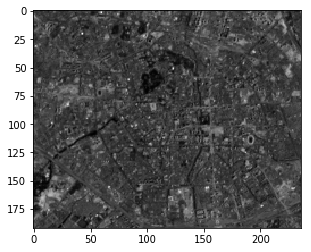

In [142]:
all_array_clip=all_array[:,pixelPosStart[0]:pixelPosEnd[0],pixelPosStart[1]:pixelPosEnd[1]]
print(all_array_clip.shape)
plt.imshow(all_array_clip[3],'gray')

In [143]:
geoTrans=list(myGetGeoTransform(dataset))
geoTrans

[232666.4555650417, 30.0, 0.0, 2800582.2118728245, 0.0, -30.0]

In [144]:
geoTrans[0],geoTrans[3]=extent[0],extent[3]
geoTrans

[265079.7877015177, 30.0, 0.0, 2774506.605645239, 0.0, -30.0]

In [150]:
def myLayer2ArrayMask(pixel_size,vector_fn):
    # Define pixel_size and NoData value of new raster
    #pixel_size = 30
    NoData_value = 255

    # Open the data source and read in the extent
    source_ds = ogr.Open(vector_fn)
    source_layer = source_ds.GetLayer()
    source_srs = source_layer.GetSpatialRef()
    x_min, x_max, y_min, y_max = source_layer.GetExtent()
    print(x_min, x_max, y_min, y_max)
    # Create the destination data source
    x_res = round((x_max - x_min) / pixel_size)
    y_res = round((y_max - y_min) / pixel_size)
    target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
    target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(NoData_value)

    # Rasterize
    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])

    # Read as array
    mask = band.ReadAsArray()
    plt.imshow(mask,'gray')
    return mask

265079.7877015177 272152.9277447241 2768763.1605392722 2774506.605645239


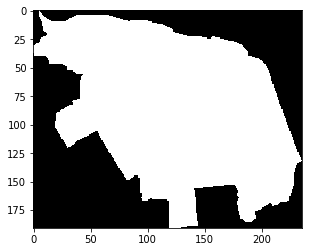

In [151]:
mask=myLayer2ArrayMask(geoTrans[1],filename)

In [149]:
mask.shape

(191, 236)

In [152]:
def mySetSameShape(mask,all_array_clip):
    maskHeight,maskWidth=mask.shape
    clipBands,clipHeight,clipWidth=all_array_clip.shape
    
    if(maskHeight>clipHeight):
        mask=mask[0:clipHeight,:]
    else:
        all_array_clip=all_array_clip[:,0:maskHeight,:]
        
    if(maskWidth>clipWidth):
        mask=mask[:,0:clipWidth]
    else:
        all_array_clip=all_array_clip[:,:,0:maskWidth]
        
    return mask,all_array_clip

In [153]:
mask,all_array_clip=mySetSameShape(mask,all_array_clip)

In [154]:
mask.shape

(191, 236)

In [155]:
all_array_clip.shape

(7, 191, 236)

In [156]:
clip=np.choose(mask,(0,all_array_clip))

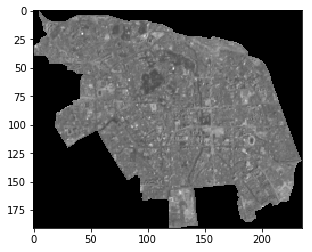

In [157]:
plt.imshow(clip[3],'gray')

In [162]:
#写文件，以写成tif为例
def write_img(filename,img_proj,img_geotrans,img_data,NODATA):
    #gdal数据类型包括
    #gdal.GDT_Byte, 
    #gdal .GDT_UInt16, gdal.GDT_Int16, gdal.GDT_UInt32, gdal.GDT_Int32,
    #gdal.GDT_Float32, gdal.GDT_Float64

    #判断栅格数据的数据类型
    list1 = ["byte","uint8","uint16","int16","uint32","int32","float32","float64","cint16","cint32","cfloat32","cfloat64"]
    list2 = [gdal.GDT_Byte,gdal.GDT_Byte,gdal.GDT_UInt16,gdal.GDT_Int16,gdal.GDT_UInt32,gdal.GDT_Int32,gdal.GDT_Float32,gdal.GDT_Float64,gdal.GDT_CInt16,gdal.GDT_CInt32,gdal.GDT_CFloat32,gdal.GDT_CFloat64]
    # print("listdatatype=",list1[1])
    # print("list1.len:",len(list1))
    # print("list2.len:",len(list2))

    datatype = gdal.GDT_Float32

    #判读数组维数
    if len(img_data.shape) > 1:
        img_bands, img_height, img_width = img_data.shape
    else:
        img_bands, (img_height, img_width) = 1,img_data.shape 

    #创建文件
    driver = gdal.GetDriverByName("GTiff")            #数据类型必须有，因为要计算需要多大内存空间
    dataset = driver.Create(filename, img_width, img_height, img_bands, datatype)

    dataset.SetGeoTransform(img_geotrans)              #写入仿射变换参数
    dataset.SetProjection(img_proj)                    #写入投影

    if img_bands == 1:
        # print("img_bands:",img_bands)
        dataset.GetRasterBand(1).SetNoDataValue(NODATA)
        dataset.GetRasterBand(1).WriteArray(img_data)  #写入数组数据
    else:
        for i in range(img_bands):
            dataset.GetRasterBand(1).SetNoDataValue(NODATA)
            dataset.GetRasterBand(i+1).WriteArray(img_data[i])

    del dataset


In [163]:
img_proj=myGetProjection(dataset)
img_geotrans=geoTrans
write_img("clipTest.tif",img_proj,img_geotrans,clip,0)

In [164]:
geoTrans

[265079.7877015177, 30.0, 0.0, 2774506.605645239, 0.0, -30.0]

In [165]:
pixelPosStart

(869, 1080)

In [166]:
pixelPosEnd

(1061, 1316)

In [167]:
geoTransOld=list(myGetGeoTransform(dataset))
geoTransOld

[232666.4555650417, 30.0, 0.0, 2800582.2118728245, 0.0, -30.0]

In [169]:
geoTransOld[0]+1080*30

265066.4555650417

In [171]:
geoTransOld[3]-869*30

2774512.2118728245

In [172]:
geoTransNew=geoTransOld
geoTransNew[0]=geoTransOld[0]+1080*30
geoTransNew[3]=geoTransOld[3]-869*30
geoTransNew

[265066.4555650417, 30.0, 0.0, 2774512.2118728245, 0.0, -30.0]

In [173]:
write_img("clipTestNew.tif",img_proj,geoTransNew,clip,0)